In [1]:
import numpy as np 
import astropy.constants as c
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import gc
import math

from scipy import stats
import statsmodels.api as sm

#list all the constants used
G=c.G.value
M_sun=c.M_sun.value
M_earth=c.M_earth.value
R_sun=c.R_sun.value
R_earth=c.R_earth.value
hour=3600 #s
day=3600*24
e=0.1
t_LC=1765.5 #s

def delta(Rp, Rs):
    delta = (Rp*R_earth / (Rs*R_sun))**2*1e6
    return delta

def SNR(delta,n,sigma_s):
    SNR=delta*n**0.5/sigma_s
    return SNR

def sigma_s(t, sigma_LC, cdppindex): #t/hour
    t_LC=1765.5/hour 

    return sigma_LC*(t/t_LC)**cdppindex

def t_dur(P,Rs,e,a): #hour
    t_dur = P*day*Rs*R_sun*(1-e**2)/(np.pi*a)/hour
    return t_dur

def a(Ms,P):
    a=((G*Ms*M_sun*(P*day)**2)/(4*np.pi**2))**(1/3)
    return a 

def n(t_obs,P): # the unite of t_obs and P is day
    n=t_obs/P
    return n

def f_n(t_obs,P):
    if t_obs <=2*P:
        return 0
    if t_obs> 2*P and t_obs< 3*P:
        return (t_obs/P-2)
    if t_obs>=3*P:
        return 1
    
def f_eff(SNR):
    if SNR <=6:
        return 0
    if SNR >6 and SNR<=12:
        return (SNR-6)/6
    if SNR>12:
        return 1
    
def f_geo(Rp,Rs,a,e):
    f_geo = (Rp*R_earth+Rs*R_sun)/(a*(1-e**2))
    return f_geo



In [2]:
data=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_2020.csv',sep=',')

In [4]:
print(data.columns)

Index(['kepid', 'ra', 'dec', 'cdpp3', 'cdpp6', 'cdpp12', 'st_quarters',
       't_obs', 'std_vra', 'std_vdec', 'mean_vra', 'mean_vdec', 'sigma_vra',
       'sigma_vdec', 'kepmag', 'teff', 'logg', 'radius', 'feh', 'mass', 'dens',
       'dist', 'av', 'jmag', 'hmag', 'kmag', 'ra_gaia', 'dec_gaia', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_g_mean_mag', 'teff_b2018', 'teffe_b2018', 'rad_b2018',
       'radep_b2018', 'radem_b2018'],
      dtype='object')


In [3]:
c1=1./1e3/3600e0*np.pi/180e0/(24e0*3600e0*365.2425e0)
c2=c.pc.value/1000
print(c1,c2)

1.5363133965204748e-16 30856775814671.914


In [4]:
data=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')

vra=[]
vdec=[]
for i in range(0,len(data)):
    temp_vra=data['pmra'][i]*c1*1e3/data['parallax'][i]*c2
    temp_vdec=data['pmdec'][i]*c1*1e3/data['parallax'][i]*c2
    vra.append(temp_vra)
    vdec.append(temp_vdec)

vra_bar=np.mean(vra)
vdec_bar=np.mean(vdec)

std_vra=np.std(vra)
std_vdec=np.std(vdec)

sigma_vra=[]
sigma_vdec=[]
for i in range(0,len(data)):
    sigma_vra.append(abs(vra[i]-vra_bar)/std_vra)
    sigma_vdec.append(abs(vdec[i]-vdec_bar)/std_vdec)

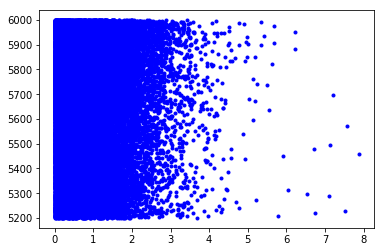

In [8]:
plt.plot(sigma_vra,data['teff_b2018'],'b.')

In [7]:
#task one we do not consider the difference of the metallicity
data=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')

vra=[]
vdec=[]
for i in range(0,len(data)):
    temp_vra=data['pmra'][i]*c1*1e3/data['parallax'][i]*c2
    temp_vdec=data['pmdec'][i]*c1*1e3/data['parallax'][i]*c2
    vra.append(temp_vra)
    vdec.append(temp_vdec)

vra_bar=np.mean(vra)
vdec_bar=np.mean(vdec)

std_vra=np.std(vra)
std_vdec=np.std(vdec)


with open('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_zero.csv','w') as f:
    s=["kepid",
        "ra",
        "dec",
        "cdpp3",
        "cdpp6",
        "cdpp12",
        'st_quarters',
        't_obs',
        "std_vra",
        "std_vdec",
        "mean_vra",
        "mean_vdec",
        "sigma_vra",
        "sigma_vdec",
        "kepmag",
        "teff",
        "logg",
        "radius",
        "feh",
        "mass",
        "dens",
        "dist",
        "av",
        "jmag",
        "hmag",
        "kmag",
        "ra_gaia",
        "dec_gaia",
        "parallax",
        "parallax_error",
        "pmra",
        "pmra_error",
        "pmdec",
        "pmdec_error",
        "phot_g_mean_mag",
        "teff_b2018",
        "teffe_b2018",
        "rad_b2018",
        "radep_b2018",
        "radem_b2018",
       'std_vra_new',
       'std_vdec_new',
       'vra',
       'vdec',
       'sigma_vra_new',
       'sigma_vdec_new',
       'mean_vra_new',
       'mean_vdec_new',
      ]
    writer=csv.DictWriter(f,fieldnames=s)
    writer.writeheader()
    for i in range(0,len(data)):
#        if data['teff_b2018'][i]>=5200 and data['teff_b2018'][i]<6000:
            writer.writerow({"kepid":data['kepid'][i],
                            "ra":data['ra'][i],
                            "dec":data['dec'][i],
                            "cdpp3":data['cdpp3'][i],
                            "cdpp6":data['cdpp6'][i],
                            "cdpp12":data['cdpp12'][i],
                            'st_quarters':data['st_quarters'][i],
                            't_obs':data['t_obs'][i],
                            "std_vra":data['std_vra'][i],
                            "std_vdec":data['std_vdec'][i],
                            "mean_vra":data['mean_vra'][i],
                            "mean_vdec":data['mean_vdec'][i],
                            "sigma_vra":data['sigma_vra'][i],
                            "sigma_vdec":data['sigma_vdec'][i],
                            "kepmag":data['kepmag'][i],
                            "teff":data['teff'][i],
                            "logg":data['logg'][i],
                            "feh":data['feh'][i],
                            "radius":data['radius'][i],
                            "mass":data['mass'][i],
                            "dens":data['dens'][i],
                            "dist":data['dist'][i],
                            "av":data['av'][i],
                            "jmag":data['jmag'][i],
                            "hmag":data['hmag'][i],
                            "kmag":data['kmag'][i],
                            "ra_gaia":data['ra_gaia'][i],
                            "dec_gaia":data['dec_gaia'][i],
                            "parallax":data['parallax'][i],
                            "parallax_error":data['parallax_error'][i],
                            "pmra":data['pmra'][i],
                            "pmra_error":data['pmra_error'][i],
                            "pmdec":data['pmdec'][i],
                            "pmdec_error":data['pmdec_error'][i],
                            "phot_g_mean_mag":data['phot_g_mean_mag'][i],
                            "teff_b2018":data['teff_b2018'][i],
                            "teffe_b2018":data['teffe_b2018'][i],
                            "rad_b2018":data['rad_b2018'][i],
                            "radep_b2018":data['radep_b2018'][i],
                            "radem_b2018":data['radem_b2018'][i],
                             
                            'std_vra_new':std_vra,
                            'std_vdec_new':std_vdec,
                            'vra':vra[i],
                            'vdec':vdec[i],
                            'mean_vra_new':vra_bar,
                            'mean_vdec_new':vdec_bar,
#                            'sigma_vra_new':(vra[i]-vra_bar)/std_vra,
#                            'sigma_vdec_new':(vdec[i]-vdec_bar)/std_vdec,
                            'sigma_vra_new':abs(vra[i]-vra_bar)/std_vra,
                            'sigma_vdec_new':abs(vdec[i]-vdec_bar)/std_vdec,

                            })


(array([1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 7.000e+00, 7.000e+00,
        1.100e+01, 9.000e+00, 2.400e+01, 1.100e+01, 2.600e+01, 3.900e+01,
        5.100e+01, 4.900e+01, 7.700e+01, 8.900e+01, 1.180e+02, 1.630e+02,
        1.830e+02, 2.220e+02, 2.870e+02, 3.520e+02, 4.200e+02, 6.300e+02,
        7.320e+02, 9.080e+02, 1.120e+03, 1.366e+03, 1.772e+03, 1.945e+03,
        2.256e+03, 2.614e+03, 2.802e+03, 2.886e+03, 3.087e+03, 3.234e+03,
        3.275e+03, 2.929e+03, 2.586e+03, 2.086e+03, 1.765e+03, 1.535e+03,
        1.073e+03, 9.670e+02, 6.420e+02, 4.840e+02, 3.610e+02, 2.500e+02,
        2.230e+02, 1.420e+02, 9.700e+01, 7.200e+01, 6.400e+01, 3.200e+01,
        3.600e+01, 1.800e+01, 2.800e+01, 2.100e+01, 1.100e+01, 1.200e+01,
        8.000e+00, 7.000e+00, 7.000e+0

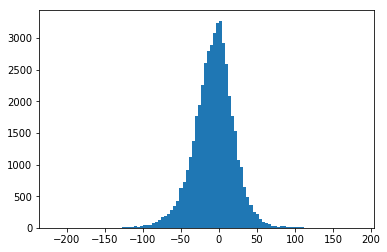

In [8]:
table=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_zero.csv')

fig=plt.figure()
plt.hist(table['vra'],100)

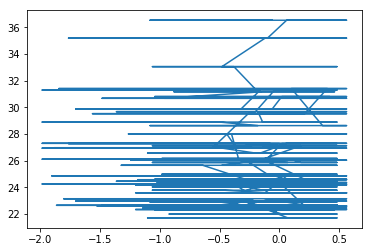

In [9]:
data=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_zero.csv')
with open('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_zero_2sigma_hot.csv','w') as f:
    s=["kepid",
        "ra",
        "dec",
        "cdpp3",
        "cdpp6",
        "cdpp12",
        'st_quarters',
        't_obs',
        "std_vra",
        "std_vdec",
        "mean_vra",
        "mean_vdec",
        "sigma_vra",
        "sigma_vdec",
        "kepmag",
        "teff",
        "logg",
        "radius",
        "feh",
        "mass",
        "dens",
        "dist",
        "av",
        "jmag",
        "hmag",
        "kmag",
        "ra_gaia",
        "dec_gaia",
        "parallax",
        "parallax_error",
        "pmra",
        "pmra_error",
        "pmdec",
        "pmdec_error",
        "phot_g_mean_mag",
        "teff_b2018",
        "teffe_b2018",
        "rad_b2018",
        "radep_b2018",
        "radem_b2018",
       'std_vra_new',
       'std_vdec_new',
       'vra',
       'vdec',
       'sigma_vra_new',
       'sigma_vdec_new',
       'mean_vra_new',
       'mean_vdec_new',
      ]
    writer=csv.DictWriter(f,fieldnames=s)
    writer.writeheader()
    for i in range(0,len(data)):
        if data['sigma_vra_new'][i]>=2 or data['sigma_vdec_new'][i]>=2:
            writer.writerow({"kepid":data['kepid'][i],
                            "ra":data['ra'][i],
                            "dec":data['dec'][i],
                            "cdpp3":data['cdpp3'][i],
                            "cdpp6":data['cdpp6'][i],
                            "cdpp12":data['cdpp12'][i],
                            'st_quarters':data['st_quarters'][i],
                            't_obs':data['t_obs'][i],
                            "std_vra":data['std_vra'][i],
                            "std_vdec":data['std_vdec'][i],
                            "mean_vra":data['mean_vra'][i],
                            "mean_vdec":data['mean_vdec'][i],
                            "sigma_vra":data['sigma_vra'][i],
                            "sigma_vdec":data['sigma_vdec'][i],
                            "kepmag":data['kepmag'][i],
                            "teff":data['teff'][i],
                            "logg":data['logg'][i],
                            "feh":data['feh'][i],
                            "radius":data['radius'][i],
                            "mass":data['mass'][i],
                            "dens":data['dens'][i],
                            "dist":data['dist'][i],
                            "av":data['av'][i],
                            "jmag":data['jmag'][i],
                            "hmag":data['hmag'][i],
                            "kmag":data['kmag'][i],
                            "ra_gaia":data['ra_gaia'][i],
                            "dec_gaia":data['dec_gaia'][i],
                            "parallax":data['parallax'][i],
                            "parallax_error":data['parallax_error'][i],
                            "pmra":data['pmra'][i],
                            "pmra_error":data['pmra_error'][i],
                            "pmdec":data['pmdec'][i],
                            "pmdec_error":data['pmdec_error'][i],
                            "phot_g_mean_mag":data['phot_g_mean_mag'][i],
                            "teff_b2018":data['teff_b2018'][i],
                            "teffe_b2018":data['teffe_b2018'][i],
                            "rad_b2018":data['rad_b2018'][i],
                            "radep_b2018":data['radep_b2018'][i],
                            "radem_b2018":data['radem_b2018'][i],
                             
                            'std_vra_new':std_vra,
                            'std_vdec_new':std_vdec,
                            'vra':vra[i],
                            'vdec':vdec[i],
                            'mean_vra_new':vra_bar,
                            'mean_vdec_new':vdec_bar,
#                            'sigma_vra_new':(vra[i]-vra_bar)/std_vra,
#                            'sigma_vdec_new':(vdec[i]-vdec_bar)/std_vdec,
                            'sigma_vra_new':abs(vra[i]-vra_bar)/std_vra,
                            'sigma_vdec_new':abs(vdec[i]-vdec_bar)/std_vdec,

                            })


In [10]:
data=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_zero.csv')
with open('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_zero_2sigma_cool.csv','w') as f:
    s=["kepid",
        "ra",
        "dec",
        "cdpp3",
        "cdpp6",
        "cdpp12",
        'st_quarters',
        't_obs',
        "std_vra",
        "std_vdec",
        "mean_vra",
        "mean_vdec",
        "sigma_vra",
        "sigma_vdec",
        "kepmag",
        "teff",
        "logg",
        "radius",
        "feh",
        "mass",
        "dens",
        "dist",
        "av",
        "jmag",
        "hmag",
        "kmag",
        "ra_gaia",
        "dec_gaia",
        "parallax",
        "parallax_error",
        "pmra",
        "pmra_error",
        "pmdec",
        "pmdec_error",
        "phot_g_mean_mag",
        "teff_b2018",
        "teffe_b2018",
        "rad_b2018",
        "radep_b2018",
        "radem_b2018",
       'std_vra_new',
       'std_vdec_new',
       'vra',
       'vdec',
       'sigma_vra_new',
       'sigma_vdec_new',
       'mean_vra_new',
       'mean_vdec_new',
      ]
    writer=csv.DictWriter(f,fieldnames=s)
    writer.writeheader()
    for i in range(0,len(data)):
        if data['sigma_vra_new'][i]<2 and data['sigma_vdec_new'][i]<2:
            writer.writerow({"kepid":data['kepid'][i],
                            "ra":data['ra'][i],
                            "dec":data['dec'][i],
                            "cdpp3":data['cdpp3'][i],
                            "cdpp6":data['cdpp6'][i],
                            "cdpp12":data['cdpp12'][i],
                            'st_quarters':data['st_quarters'][i],
                            't_obs':data['t_obs'][i],
                            "std_vra":data['std_vra'][i],
                            "std_vdec":data['std_vdec'][i],
                            "mean_vra":data['mean_vra'][i],
                            "mean_vdec":data['mean_vdec'][i],
                            "sigma_vra":data['sigma_vra'][i],
                            "sigma_vdec":data['sigma_vdec'][i],
                            "kepmag":data['kepmag'][i],
                            "teff":data['teff'][i],
                            "logg":data['logg'][i],
                            "feh":data['feh'][i],
                            "radius":data['radius'][i],
                            "mass":data['mass'][i],
                            "dens":data['dens'][i],
                            "dist":data['dist'][i],
                            "av":data['av'][i],
                            "jmag":data['jmag'][i],
                            "hmag":data['hmag'][i],
                            "kmag":data['kmag'][i],
                            "ra_gaia":data['ra_gaia'][i],
                            "dec_gaia":data['dec_gaia'][i],
                            "parallax":data['parallax'][i],
                            "parallax_error":data['parallax_error'][i],
                            "pmra":data['pmra'][i],
                            "pmra_error":data['pmra_error'][i],
                            "pmdec":data['pmdec'][i],
                            "pmdec_error":data['pmdec_error'][i],
                            "phot_g_mean_mag":data['phot_g_mean_mag'][i],
                            "teff_b2018":data['teff_b2018'][i],
                            "teffe_b2018":data['teffe_b2018'][i],
                            "rad_b2018":data['rad_b2018'][i],
                            "radep_b2018":data['radep_b2018'][i],
                            "radem_b2018":data['radem_b2018'][i],
                             
                            'std_vra_new':std_vra,
                            'std_vdec_new':std_vdec,
                            'vra':vra[i],
                            'vdec':vdec[i],
                            'mean_vra_new':vra_bar,
                            'mean_vdec_new':vdec_bar,
#                            'sigma_vra_new':(vra[i]-vra_bar)/std_vra,
#                            'sigma_vdec_new':(vdec[i]-vdec_bar)/std_vdec,
                            'sigma_vra_new':abs(vra[i]-vra_bar)/std_vra,
                            'sigma_vdec_new':abs(vdec[i]-vdec_bar)/std_vdec,

                            })


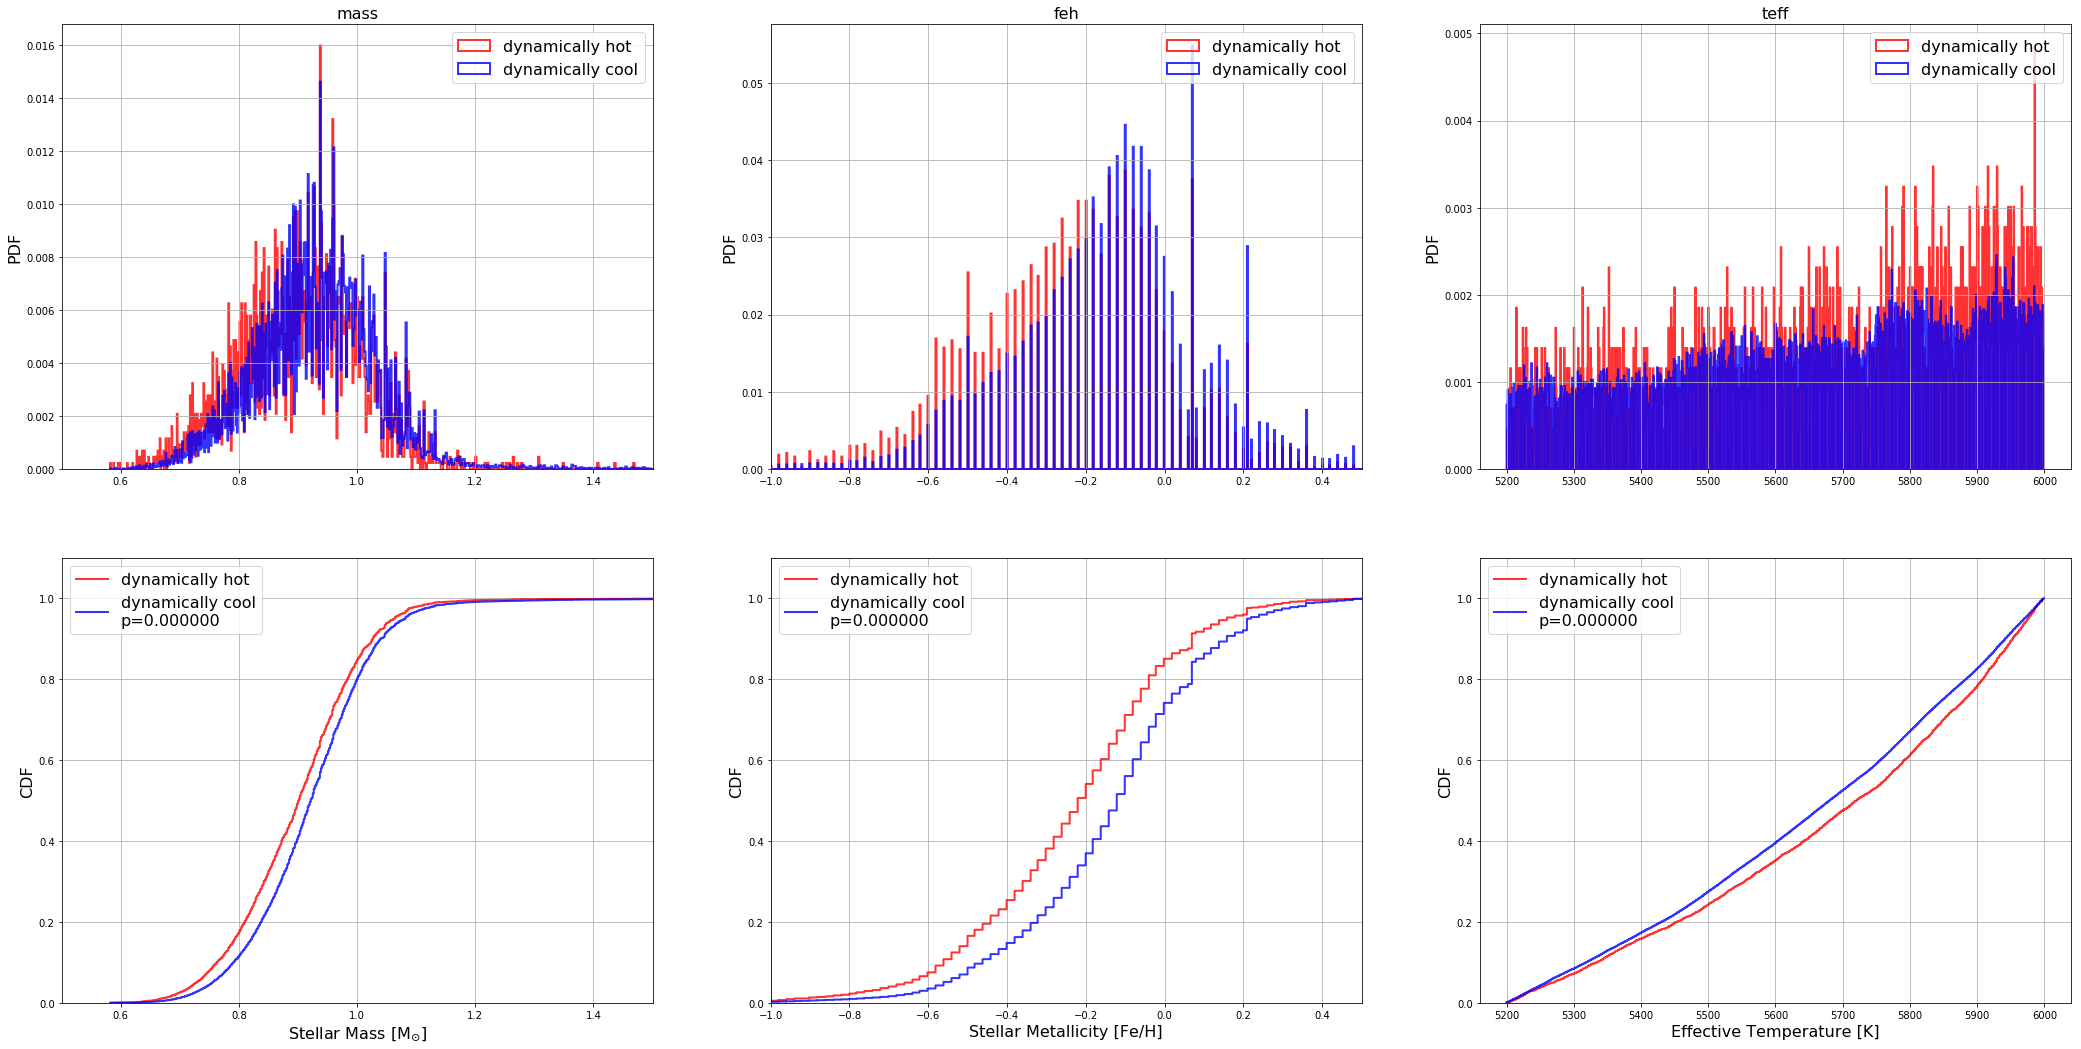

In [11]:
data1=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_zero_2sigma_hot.csv')
data2=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_zero_2sigma_cool.csv')


#mass correlation
hot_mass=data1['mass']
cool_mass=data2['mass']


s1=stats.ks_2samp(hot_mass,cool_mass)
fig=plt.figure(figsize=(36,18))
ax13=plt.subplot(2,3,1)
bins=np.logspace(np.log10(min(min(hot_mass),min(cool_mass))),np.log10(max(max(hot_mass),max(cool_mass))),1000)
weights1 = np.ones_like(hot_mass)/float(len(hot_mass))

ax13.hist(hot_mass,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(cool_mass)/float(len(cool_mass))
ax13.hist(cool_mass,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')#+'\n'+'p='+'{:3e}'.format(s1[1]))
ax13.grid(True)
#plt.setp(ax13.get_xticklabels(), visible=False)
ax13.legend(loc='best',fontsize=16)
ax13.set_ylabel("PDF",fontsize=16)
#ax13.set_xscale('log')
ax13.set_xlim(0.5,1.5)

ax14=plt.subplot(2,3,4)
ecdf=sm.distributions.ECDF(hot_mass)
counts1=ecdf(bins)
ax14.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(cool_mass)
counts2=ecdf(bins)
ax14.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:3f}'.format(s1[1]))
ax14.set_xlabel("Stellar Mass [M$_{\odot}$]",fontsize=16)
ax14.set_ylabel("CDF",fontsize=16)
ax14.set_ylim(0,1.1)
ax14.grid(True)
ax14.legend(loc='best',fontsize=16)
#ax14.set_xscale('log')
ax14.set_xlim(0.5,1.5)
#ax14.text('D = 0.1099')

#feh correlation
hot_feh=data1['feh']
cool_feh=data2['feh']

s1=stats.ks_2samp(hot_feh,cool_feh)
#fig=plt.figure(figsize=(36,18))
ax15=plt.subplot(2,3,2)
bins=np.linspace(min(min(hot_feh),min(cool_feh)),max(max(hot_feh),max(cool_feh)),1000)
weights1 = np.ones_like(hot_feh)/float(len(hot_feh))

ax15.hist(hot_feh,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(cool_feh)/float(len(cool_feh))
ax15.hist(cool_feh,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
ax15.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
ax15.legend(loc='best',fontsize=16)
ax15.set_ylabel("PDF",fontsize=16)
#ax15.set_xscale('log')
ax15.set_xlim(-1,0.5)

ax16=plt.subplot(2,3,5)
ecdf=sm.distributions.ECDF(hot_feh)
counts1=ecdf(bins)
ax16.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(cool_feh)
counts2=ecdf(bins)
ax16.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:3f}'.format(s1[1]))
ax16.set_xlabel("Stellar Metallicity [Fe/H]",fontsize=16)
ax16.set_ylabel("CDF",fontsize=16)
ax16.set_ylim(0,1.1)
ax16.grid(True)
ax16.legend(loc='best',fontsize=16)
#ax16.set_xscale('log')
ax16.set_xlim(-1,0.5)
#ax16.text('D = 0.1099')


hot_teff=data1['teff_b2018']
cool_teff=data2['teff_b2018']

s1=stats.ks_2samp(hot_teff,cool_teff)
#fig=plt.figure(figsize=(36,18))
ax17=plt.subplot(2,3,3)
bins=np.linspace(min(min(hot_teff),min(cool_teff)),max(max(hot_teff),max(cool_teff)),1000)
weights1 = np.ones_like(hot_teff)/float(len(hot_teff))

ax17.hist(hot_teff,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(cool_teff)/float(len(cool_teff))
ax17.hist(cool_teff,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
ax17.grid(True)
#plt.setp(ax17.get_xticklabels(), visible=False)
ax17.legend(loc='best',fontsize=16)
ax17.set_ylabel("PDF",fontsize=16)
#ax17.set_xscale('log')

ax18=plt.subplot(2,3,6)
ecdf=sm.distributions.ECDF(hot_teff)
counts1=ecdf(bins)
ax18.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(cool_teff)
counts2=ecdf(bins)
ax18.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:3f}'.format(s1[1]))
ax18.set_xlabel("Effective Temperature [K]",fontsize=16)
ax18.set_ylabel("CDF",fontsize=16)
ax18.set_ylim(0,1.1)
ax18.grid(True)
delta=[]
for i in range(0,len(bins)):
    delta.append(counts1[i]-counts2[i])
    
id_Dvalue=np.argmax(delta)
teff_dvalue=bins[id_Dvalue]
yy=np.linspace(counts2[id_Dvalue],counts1[id_Dvalue],1000)
xx=[bins[id_Dvalue]]*1000
ax18.plot(xx,yy,'k-')#,linewidth=5,label='D ='+' {:5f}'.format(s1[0])+'\n'+'P ='+' {:5f}'.format(s1[1]))
ax18.legend(loc='best',fontsize=16)
#ax12.set_xscale('log')
#ax12.text('D = 0.1099')

#ax18.annotate('D ='+' {:5f}'.format(s1[0])+'\n'+'P ='+' {:5f}'.format(s1[1]), xy=(bins[id_Dvalue], counts2[id_Dvalue]), xytext=(8000, 0.6),
#            arrowprops=dict(facecolor='black', shrink=0.05),fontsize=16)



ax13.set_title('mass',fontsize=16)
ax15.set_title('feh',fontsize=16)
ax17.set_title('teff',fontsize=16)
plt.savefig('result/G_zero_hot_cool_2sigma_correlation.eps',dpi=300)
plt.show()

In [12]:
#draw the PDF CDF to show the difference of FeH distribution between the two group
data1=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_no_feh.csv')
data2=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_no_feh_2sigma.csv')

fig=plt.figure()
bins=np.linspace(-1,0.5,100)
plt.hist(data1['feh'],bins)
plt.xlim(-1,0.5)

fig=plt.figure()
plt.hist(data2['feh'],bins)
plt.xlim(-1,0.5)

fig=plt.figure()
bins=np.linspace(min(data1['teff_b2018']),max(data1['teff_b2018']),100)
plt.hist(data1['teff_b2018'],bins)
#plt.xlim(-1,0.5)

fig=plt.figure()
plt.hist(data2['teff_b2018'],bins)
#plt.xlim(-1,0.5)


fig=plt.figure()
bins=np.linspace(0.5,1.5,100)
plt.hist(data1['mass'],bins)
#plt.xlim(-1,0.5)

fig=plt.figure()
plt.hist(data2['mass'],bins)
#plt.xlim(-1,0.5)


print(np.median(data1['feh']),np.median(data2['feh']))

print(np.median(data1['teff_b2018']),np.median(data2['teff_b2018']))

FileNotFoundError: File b'data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_no_feh.csv' does not exist

In [9]:
data=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')
print(data)

          kepid         ra        dec    cdpp3    cdpp6   cdpp12  \
0       2441862  291.10583  37.761162  155.849  128.596  112.388   
1       6362395  291.26816  41.719559  223.063  187.579  177.446   
2       8555473  290.12607  44.659081  131.376  101.292   82.939   
3      10136837  290.18085  47.133839  167.130  123.841   92.214   
4       8555546  290.15100  44.614601  142.850  105.586   79.934   
5      12103067  286.60526  50.600929  245.386  200.377  175.242   
6       2441876  291.10974  37.774509   51.370   39.310   31.584   
7       8555587  290.16394  44.681419  266.841  197.396  149.033   
8       6362412  291.27515  41.744820  222.202  177.865  150.863   
9      12103092  286.62656  50.614769  245.854  187.015  149.172   
10      8555593  290.16510  44.672760  101.258   78.894   64.671   
11      6362416  291.27664  41.772739  134.543   97.296   72.036   
12     12104062  287.37277  50.677631   90.262   74.312   66.653   
13      6362469  291.29340  41.744659  231.155  

In [36]:
data.sort_values(by='feh',axis=0, ascending=True)
print(data)

          kepid         ra        dec    cdpp3    cdpp6   cdpp12  \
0       2441862  291.10583  37.761162  155.849  128.596  112.388   
1       6362395  291.26816  41.719559  223.063  187.579  177.446   
2       8555473  290.12607  44.659081  131.376  101.292   82.939   
3      10136837  290.18085  47.133839  167.130  123.841   92.214   
4       8555546  290.15100  44.614601  142.850  105.586   79.934   
5      12103067  286.60526  50.600929  245.386  200.377  175.242   
6       2441876  291.10974  37.774509   51.370   39.310   31.584   
7       8555587  290.16394  44.681419  266.841  197.396  149.033   
8       6362412  291.27515  41.744820  222.202  177.865  150.863   
9      12103092  286.62656  50.614769  245.854  187.015  149.172   
10      8555593  290.16510  44.672760  101.258   78.894   64.671   
11      6362416  291.27664  41.772739  134.543   97.296   72.036   
12     12104062  287.37277  50.677631   90.262   74.312   66.653   
13      6362469  291.29340  41.744659  231.155  

In [15]:
data=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_feh_ascending.csv',sep=',')

interval=int(len(data)/50)

vra=[]
vdec=[]
vra_bar=[]
vdec_bar=[]
std_vra=[]
std_vdec=[]

vra_bar_new=[]
vdec_bar_new=[]
std_vra_new=[]
std_vdec_new=[]


for j in range(0,49):
    temp_vra=[]
    temp_vdec=[]
    for i in range(j*interval,interval*(j+1)):
        temp_vra.append(data['pmra'][i]*c1*1e3/data['parallax'][i]*c2)
        temp_vdec.append(data['pmdec'][i]*c1*1e3/data['parallax'][i]*c2)
        vra.append(data['pmra'][i]*c1*1e3/data['parallax'][i]*c2)
        vdec.append(data['pmra'][i]*c1*1e3/data['parallax'][i]*c2)
    

    vra_bar.append(np.mean(temp_vra))
    vdec_bar.append(np.mean(temp_vdec))

    std_vra.append(np.std(temp_vra))
    std_vdec.append(np.std(temp_vdec))
    
    for i in range(j*interval,interval*(j+1)):
        vra_bar_new.append(vra_bar[j])
        vdec_bar_new.append(vdec_bar[j])
        std_vra_new.append(std_vra[j])
        std_vdec_new.append(std_vdec[j])


j=49
temp_vra=[]
temp_vdec=[]
for i in range(j*interval,len(data)):
    temp_vra.append(data['pmra'][i]*c1*1e3/data['parallax'][i]*c2)
    temp_vdec.append(data['pmdec'][i]*c1*1e3/data['parallax'][i]*c2)
    vra.append(data['pmra'][i]*c1*1e3/data['parallax'][i]*c2)
    vdec.append(data['pmra'][i]*c1*1e3/data['parallax'][i]*c2)

vra_bar.append(np.mean(temp_vra))
vdec_bar.append(np.mean(temp_vdec))

std_vra.append(np.std(temp_vra))
std_vdec.append(np.std(temp_vdec))

for i in range(j*interval,len(data)):
    vra_bar_new.append(vra_bar[j])
    vdec_bar_new.append(vdec_bar[j])
    std_vra_new.append(std_vra[j])
    std_vdec_new.append(std_vdec[j])



In [11]:
print(std_vra_new)#,std_vdec_new,vra_bar_new,vdec_bar_new)

[37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208147757, 37.13124208

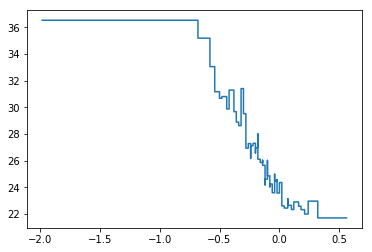

In [16]:
plt.plot(data['feh'],std_vra_new)

In [11]:
len(std_vra_new),len(data)

(46281, 46281)

In [17]:
#second we calculate the velocity dispersion within the same range of effective temperature

#task one we do not consider the difference of the metallicity
'''
data=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G.csv',sep=',')

interval=int(len(data)/50)

vra=[]
vdec=[]
for j in range(0,50):
temp_vra=[]
temp_vdec=[]
    for i in range(j*interval,interval*(j+1)):
        temp_vra.append(data['pmra'][i]*c1*1e3/data['parallax'][i]*c2)
        temp_vdec.append(data['pmdec'][i]*c1*1e3/data['parallax'][i]*c2)
        vra.append(data['pmra'][i]*c1*1e3/data['parallax'][i]*c2)
        vdec.append(data['pmra'][i]*c1*1e3/data['parallax'][i]*c2)

vra_bar=np.mean(vra)
vdec_bar=np.mean(vdec)

std_vra=np.std(vra)
std_vdec=np.std(vdec)

'''
data=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_feh_ascending.csv',sep=',')
with open('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_feh.csv','w') as f:
    s=["kepid",
        "ra",
        "dec",
        "cdpp3",
        "cdpp6",
        "cdpp12",
        'st_quarters',
        't_obs',
        "std_vra",
        "std_vdec",
        "mean_vra",
        "mean_vdec",
        "sigma_vra",
        "sigma_vdec",
        "kepmag",
        "teff",
        "logg",
        "radius",
        "feh",
        "mass",
        "dens",
        "dist",
        "av",
        "jmag",
        "hmag",
        "kmag",
        "ra_gaia",
        "dec_gaia",
        "parallax",
        "parallax_error",
        "pmra",
        "pmra_error",
        "pmdec",
        "pmdec_error",
        "phot_g_mean_mag",
        "teff_b2018",
        "teffe_b2018",
        "rad_b2018",
        "radep_b2018",
        "radem_b2018",
       'std_vra_new',
       'std_vdec_new',
       'vra',
       'vdec',
       'sigma_vra_new',
       'sigma_vdec_new',
       'mean_vra_new',
       'mean_vdec_new',
      ]
    writer=csv.DictWriter(f,fieldnames=s)
    writer.writeheader()
    for i in range(0,len(data)):
#        if data['teff_b2018'][i]>=5200 and data['teff_b2018'][i]<6000:
            writer.writerow({"kepid":data['kepid'][i],
                            "ra":data['ra'][i],
                            "dec":data['dec'][i],
                            "cdpp3":data['cdpp3'][i],
                            "cdpp6":data['cdpp6'][i],
                            "cdpp12":data['cdpp12'][i],
                            'st_quarters':data['st_quarters'][i],
                            't_obs':data['t_obs'][i],
                            "std_vra":data['std_vra'][i],
                            "std_vdec":data['std_vdec'][i],
                            "mean_vra":data['mean_vra'][i],
                            "mean_vdec":data['mean_vdec'][i],
                            "sigma_vra":data['sigma_vra'][i],
                            "sigma_vdec":data['sigma_vdec'][i],
                            "kepmag":data['kepmag'][i],
                            "teff":data['teff'][i],
                            "logg":data['logg'][i],
                            "feh":data['feh'][i],
                            "radius":data['radius'][i],
                            "mass":data['mass'][i],
                            "dens":data['dens'][i],
                            "dist":data['dist'][i],
                            "av":data['av'][i],
                            "jmag":data['jmag'][i],
                            "hmag":data['hmag'][i],
                            "kmag":data['kmag'][i],
                            "ra_gaia":data['ra_gaia'][i],
                            "dec_gaia":data['dec_gaia'][i],
                            "parallax":data['parallax'][i],
                            "parallax_error":data['parallax_error'][i],
                            "pmra":data['pmra'][i],
                            "pmra_error":data['pmra_error'][i],
                            "pmdec":data['pmdec'][i],
                            "pmdec_error":data['pmdec_error'][i],
                            "phot_g_mean_mag":data['phot_g_mean_mag'][i],
                            "teff_b2018":data['teff_b2018'][i],
                            "teffe_b2018":data['teffe_b2018'][i],
                            "rad_b2018":data['rad_b2018'][i],
                            "radep_b2018":data['radep_b2018'][i],
                            "radem_b2018":data['radem_b2018'][i],
                             
                            'std_vra_new':std_vra_new[i],
                            'std_vdec_new':std_vdec_new[i],
                            'vra':vra[i],
                            'vdec':vdec[i],
                            'mean_vra_new':vra_bar_new[i],
                            'mean_vdec_new':vdec_bar_new[i],
#                            'sigma_vra_new':(vra[i]-vra_bar)/std_vra,
#                            'sigma_vdec_new':(vdec[i]-vdec_bar)/std_vdec,
                            'sigma_vra_new':abs(vra[i]-vra_bar_new[i])/std_vra_new[i],
                            'sigma_vdec_new':abs(vdec[i]-vdec_bar_new[i])/std_vdec_new[i],

                            })


In [18]:
data=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_feh.csv',sep=',')
with open('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_feh_2sigma.csv','w') as f:
    s=["kepid",
        "ra",
        "dec",
        "cdpp3",
        "cdpp6",
        "cdpp12",
        'st_quarters',
        't_obs',
        "std_vra",
        "std_vdec",
        "mean_vra",
        "mean_vdec",
        "sigma_vra",
        "sigma_vdec",
        "kepmag",
        "teff",
        "logg",
        "radius",
        "feh",
        "mass",
        "dens",
        "dist",
        "av",
        "jmag",
        "hmag",
        "kmag",
        "ra_gaia",
        "dec_gaia",
        "parallax",
        "parallax_error",
        "pmra",
        "pmra_error",
        "pmdec",
        "pmdec_error",
        "phot_g_mean_mag",
        "teff_b2018",
        "teffe_b2018",
        "rad_b2018",
        "radep_b2018",
        "radem_b2018",
       'std_vra_new',
       'std_vdec_new',
       'vra',
       'vdec',
       'sigma_vra_new',
       'sigma_vdec_new',
       'mean_vra_new',
       'mean_vdec_new',
      ]
    writer=csv.DictWriter(f,fieldnames=s)
    writer.writeheader()
    for i in range(0,len(data)):
        if data['sigma_vra'][i]>=2 or data['sigma_vdec'][i]>=2:
            writer.writerow({"kepid":data['kepid'][i],
                            "ra":data['ra'][i],
                            "dec":data['dec'][i],
                            "cdpp3":data['cdpp3'][i],
                            "cdpp6":data['cdpp6'][i],
                            "cdpp12":data['cdpp12'][i],
                            'st_quarters':data['st_quarters'][i],
                            't_obs':data['t_obs'][i],
                            "std_vra":data['std_vra'][i],
                            "std_vdec":data['std_vdec'][i],
                            "mean_vra":data['mean_vra'][i],
                            "mean_vdec":data['mean_vdec'][i],
                            "sigma_vra":data['sigma_vra'][i],
                            "sigma_vdec":data['sigma_vdec'][i],
                            "kepmag":data['kepmag'][i],
                            "teff":data['teff'][i],
                            "logg":data['logg'][i],
                            "feh":data['feh'][i],
                            "radius":data['radius'][i],
                            "mass":data['mass'][i],
                            "dens":data['dens'][i],
                            "dist":data['dist'][i],
                            "av":data['av'][i],
                            "jmag":data['jmag'][i],
                            "hmag":data['hmag'][i],
                            "kmag":data['kmag'][i],
                            "ra_gaia":data['ra_gaia'][i],
                            "dec_gaia":data['dec_gaia'][i],
                            "parallax":data['parallax'][i],
                            "parallax_error":data['parallax_error'][i],
                            "pmra":data['pmra'][i],
                            "pmra_error":data['pmra_error'][i],
                            "pmdec":data['pmdec'][i],
                            "pmdec_error":data['pmdec_error'][i],
                            "phot_g_mean_mag":data['phot_g_mean_mag'][i],
                            "teff_b2018":data['teff_b2018'][i],
                            "teffe_b2018":data['teffe_b2018'][i],
                            "rad_b2018":data['rad_b2018'][i],
                            "radep_b2018":data['radep_b2018'][i],
                            "radem_b2018":data['radem_b2018'][i],
                             
                            'std_vra_new':std_vra_new[i],
                            'std_vdec_new':std_vdec_new[i],
                            'vra':vra[i],
                            'vdec':vdec[i],
                            'mean_vra_new':vra_bar_new[i],
                            'mean_vdec_new':vdec_bar_new[i],
#                            'sigma_vra_new':(vra[i]-vra_bar)/std_vra,
#                            'sigma_vdec_new':(vdec[i]-vdec_bar)/std_vdec,
                            'sigma_vra_new':abs(vra[i]-vra_bar_new[i])/std_vra_new[i],
                            'sigma_vdec_new':abs(vdec[i]-vdec_bar_new[i])/std_vdec_new[i],

                            })


-0.12 -0.22
5684.0 5686.0


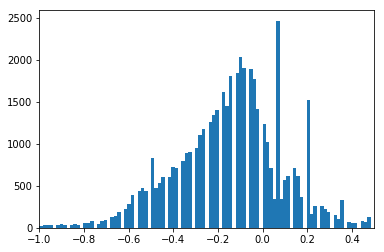

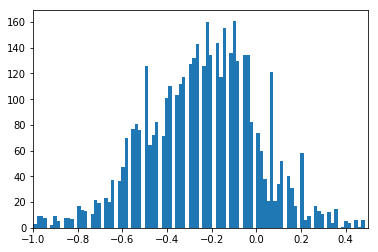

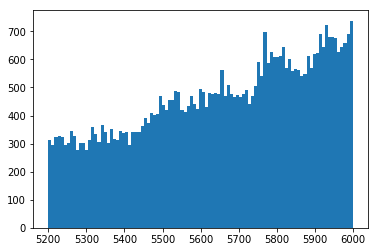

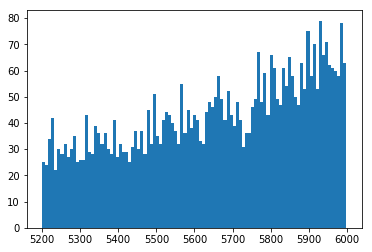

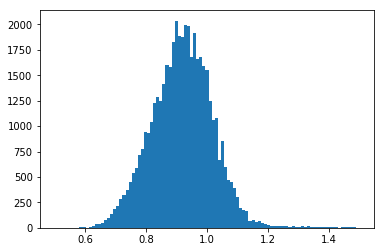

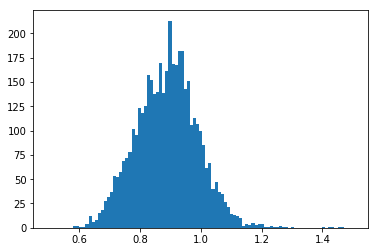

In [19]:
#draw the PDF CDF to show the difference of FeH distribution between the two group
data1=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_feh.csv')
data2=pd.read_csv('data/kepler_stellar_q17_add_dispersions_reduction_reduction_G_feh_2sigma.csv')

fig=plt.figure()
bins=np.linspace(-1,0.5,100)
plt.hist(data1['feh'],bins)
plt.xlim(-1,0.5)

fig=plt.figure()
plt.hist(data2['feh'],bins)
plt.xlim(-1,0.5)

fig=plt.figure()
bins=np.linspace(min(data1['teff_b2018']),max(data1['teff_b2018']),100)
plt.hist(data1['teff_b2018'],bins)
#plt.xlim(-1,0.5)

fig=plt.figure()
plt.hist(data2['teff_b2018'],bins)
#plt.xlim(-1,0.5)


fig=plt.figure()
bins=np.linspace(0.5,1.5,100)
plt.hist(data1['mass'],bins)
#plt.xlim(-1,0.5)

fig=plt.figure()
plt.hist(data2['mass'],bins)
#plt.xlim(-1,0.5)


print(np.median(data1['feh']),np.median(data2['feh']))

print(np.median(data1['teff_b2018']),np.median(data2['teff_b2018']))